# Eric Christopher Browne
# University of Denver: Masters in Data Science
# COMP 4447: Data Science Tools 1
# Final Project: Win Rate Prediction in Rainbow Six Siege

## <u> Part 1: Introduction</u>


Rainbow Six Siege is an extremely competitive first person shooter, real time strategy video game created in 2015, developed by Ubisoft.  Almost like a hybrid of Call of Duty and Overwatch, this game is multi-leveled in terms of gameplay, and requires a vast amount of skill in order to be the best.  

Each match consists of two roles: Attackers and Defenders, having teams of 5 switch off between roles every 3 rounds.  The match is won once a team geets to 4 round wins, winning by atleast 2.  Overtime is initiated if the score is tied 3-3, in which case its first to 5 round wins.  These matches take place over a variety of 'maps', or game environments, and each team has certain 'Operators' or in game characters to play as.  Attacker Operators and Defender Operators are completely different in their special abilities, guns, and speed/armor statistics.  This was just an overview of Rainbow Six Siege, however a detailed description of the game can be found at this link:
+ https://www.ubisoft.com/en-us/game/rainbow-six/siege

And Video description at:
+ https://www.youtube.com/watch?v=n6g9iwICQ9k

Competitive video games are all centered around a finite and sensitive balance in their game mechanics and rules; meaning that ideally, nothing is either too overpowered to guarantee a win, or too underpowered and completely useless.  To maintain this balance, games are often updated frequently to fine tune these mechanics to ensure proper balance at all times; or at least as close as game developers can make it.  Because of this, it would be very useful to model if a game was in fact truly balanced or not, and which mechanics should be changed, or completely removed from the game.

An example of an extreme imbalance might be for a given map, the Attackers win 90% of the rounds played.  This would mean that if your team were the Attackers, and keeping skill level between teams constant, that your team almost had a guaranteed win.  

Fortunately, Ubisoft has released two datasets in 2017 of operator and map statistics, so in this project I will utilize both to determine which game mechanics, if any, are not truly balanced.  To accomplish this task, I will be predicting the Win/Loss Ratio for given Attacker and Defender Operators on a given map, as well as Win/Loss Ratio for Attackers and Defenders in general, in a given map.  

#### Win/Loss Ratio (WL Ratio):  This statistic is calculated by dividing the amount of wins by the amount of losses.  Basically its how many wins you get per 1 loss.

A Win/Loss ratio statistic is a very clear indicator of in-game balance, as a truly balanced game will have operators at a 1.0 Win/Loss, and every map modeled at a 1.0 Win/Loss.  If this statistic is too great or too little, then that would be an indication of am imbalance, and therefore not suitable for truly competitive gameplay.



Concluding the Introduction, lets now import all of the libraries that will be required for this project.  If you do not already have these downloaded, make sure to do so with either a conda install or pip install.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
import seaborn as sns
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

## <u> Part 2: Data Collection </u>

Lets first start with reading in both datasets for operators and objectives using Pandas:

In [80]:
# Read in Datasets:
operators = pd.read_csv('S5_operators.csv',sep = ';')
objectives = pd.read_csv('S5_objectives.csv', sep = ';')


In [81]:
# Take a look at the operators dataset
operators.head()

,platform,dateid,skillrank,role,operator,primaryweapon,secondaryweapon,secondarygadget,nbwins,nbkills,nbdeaths,nbpicks
0,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,M249,PRB92,CLAYMORE,6,6,6,8
1,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,M249,PRB92,STUN GRENADE,4,2,6,8
2,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,PARA-308,PRB92,CLAYMORE,37,40,49,70
3,PC,20170210,Bronze,Attacker,BOPE-CAPITAO,PARA-308,PRB92,STUN GRENADE,17,24,31,41
4,PC,20170210,Bronze,Attacker,G.E.O.-JACKAL,C7E,ITA12S,BREACH CHARGE,74,123,127,174


In [82]:
# Take a look at the objectives ddata set
objectives.head()

,platform,dateid,gamemode,mapname,objectivelocation,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks
0,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,G.E.O.-JACKAL,0,0,1,1
1,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,GIGN-MONTAGNE,1,0,2,3
2,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,GSG9-IQ,0,0,1,1
3,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,JTF2-BUCK,0,0,1,1
4,PC,20170210,PvP . BOMB,BANK,EXECUTIVE LOUNGE / CEO OFFICE,Bronze,Attacker,SAS-THATCHER,0,0,1,1


In [83]:
# How big is the data?
print(operators.shape)
print(objectives.shape)

(509692, 12)
(999998, 12)


From looking at the head of both DataFrames, we can get a feel for how the data looks.  Here is some further explanation as to what each column represents:

### Objectives:
1. platform:  PC, XBOX, Playstation 4
2. Dateid: Date the match was played on
3. gamemode:  Which in game mode was played (Bomb, Hostage, Secure Area)
4. mapname:  Which in game map or environment the match was played on
5. objectivelocation:  Which objective sight was that round of the match played on (There are multiple in each map)
6. skillrank: What the overall skill ranking of every player in the match was
7. role: Attacker or Defender
8. operator: Which operator was picked for that round for a given player
9. nbwins: Amount of wins that match (0 or 1)
10. nbkills: Amount of kills that match
11. nbdeaths: Amount of deaths that match
12. nbpicks: Amount of rounds played

### Operators:
1. platform:  PC, XBOX, Playstation 4
2. Dateid: Date the match was played on
3. skillrank: Overall skill ranking of every player in the match
4. role: Attacker or Defender
5. operator: Which operator was picked for that round for a given player
6. primaryweapon: Which primary weapon they picked 
7. secondaryweapon: Which secondary weapon they picked
8. secondarygadget:  Which secondary gadget they picked.  (Primary gadget is fixed depending on which operator was chosen)
9. nbwins: Amount of wins that match (0 or 1)
10. nbkills: Amount of kills that match
11. nbdeaths: Amount of deaths that match
12. nbpicks: Amount of rounds played

If you would like to learn more about these variables, I would recommend that you explore the link(s) provided in the introduction; to better equip yourself with game knowledge and understanding.

## <u> Part 3: Cleaning Data </u>

Initially Ubisoft had already been preprocessed on the 'platform' column to include only PC values in both datasets.  This is because the gameplay is significantly more competetive when playing on a PC compared to consoles, i.e. XBOX, PS4.  This should be permitted, as we will still receive a proper analysis and conlcusion from this trimmed data.

Additionally, the columns: 'dateid', 'primaryweapon', and 'secondaryweapon' will be dropped, as weapon loadouts and dates of the matches are of no particular interest in this project.  This is because although there are multiple weapon loadout possibilities for each operator, I am primarily concerned with how overall operator choice changes across rank; as well as overall effectiveness of team composition for different operators.

Finally, I will collapse rows in the dataframe, grouping the data by 'skillrank', 'role', and 'operator', as well as summing 'nbkills','nbdeaths','nbwins', and 'nbpicks' for each group.  

In [84]:
# Using only PC platform rows, then deleting dateid, platform, primaryweapon, secondaryweapon, and gadget columns
operators = operators.loc[operators['platform'] == ('PC')]
operators.drop(['dateid','platform','primaryweapon','secondaryweapon','secondarygadget'], axis=1, inplace=True)

# Group: skillrank, role, and operator
# Sum up rounds won, kills, deaths, and rounds played across all ranks for each group
operators = operators.groupby(['skillrank','role', 'operator'], as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()
operators.head()

,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks
0,Bronze,Attacker,BOPE-CAPITAO,7131,9507,11290,15383
1,Bronze,Attacker,G.E.O.-JACKAL,21358,32434,32760,45492
2,Bronze,Attacker,GIGN-MONTAGNE,12175,9773,19389,26981
3,Bronze,Attacker,GIGN-RESERVE,377,432,701,946
4,Bronze,Attacker,GIGN-TWITCH,25733,35115,36318,53941


Besides operators, I would also like to modify the objectives DataFrame.  All types under 'gamemore' column are preceded with 'PVP' (Player versus Player).  Every single entry of data is PVP, so I shall remove this part of the string.  To do this, we shall use a nifty Pandas tool: pd.series.replace

In [85]:
## Unique values of the gamemode column:
objectives['gamemode'].unique()

array(['PvP . BOMB', 'PvP . HOSTAGE', 'PvP . SECURE AREA'], dtype=object)

In [86]:
# Grabbing all values under the column gamemode
gamemodes = objectives['gamemode']

# Using replace to remove the prefix using regex and inplace
gamemodes.replace(to_replace='PvP . ', value='', regex=True, inplace=True)
objectives['gamemode'] = gamemodes
print(objectives['gamemode'].unique())

['BOMB' 'HOSTAGE' 'SECURE AREA']


Next, I will remove the 'objectivelocation','dateid', and 'platform' columns.  Objective location is similar to weapon loadouts, in that they offer a dimension of complication that is not required for the analysis.  By eliminating the objective location variable, we will only look at the map as a whole.

Then, I will group by 'gamemode', 'mapname', 'role', and 'operator'.  

In [87]:
# Deleting dateid, objectivelocation, and platform columns
objectives.drop(['dateid','platform','objectivelocation'], axis=1, inplace=True)

# Group: gamemode, mapname, skillname, role, and operator
# Sum up rounds won, kills, deaths, and rounds played across all ranks for each group
objectives = objectives.groupby(['gamemode', 'mapname', 'skillrank', 'role', 'operator'], \
                                        as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()
objectives.head()

,gamemode,mapname,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks
0,BOMB,BANK,Bronze,Attacker,BOPE-CAPITAO,58,78,96,126
1,BOMB,BANK,Bronze,Attacker,G.E.O.-JACKAL,152,286,249,354
2,BOMB,BANK,Bronze,Attacker,GIGN-MONTAGNE,69,55,133,174
3,BOMB,BANK,Bronze,Attacker,GIGN-RESERVE,2,3,8,10
4,BOMB,BANK,Bronze,Attacker,GIGN-TWITCH,160,214,256,377


Now, I would like to remove the RESERVE operators, as they are only picked when you have no other operator to play, which is almost never.

In [88]:
## Removing Reserve operators:
operators = operators[~operators.operator.str.contains("RESERVE", na=False)]
objectives = objectives[~objectives.operator.str.contains("RESERVE", na=False)]

In [89]:
print(operators.operator.unique())
print(objectives.operator.unique())

['BOPE-CAPITAO' 'G.E.O.-JACKAL' 'GIGN-MONTAGNE' 'GIGN-TWITCH' 'GSG9-BLITZ'
 'GSG9-IQ' 'JTF2-BUCK' 'NAVYSEAL-BLACKBEARD' 'SAS-SLEDGE' 'SAS-THATCHER'
 'SAT-HIBANA' 'SPETSNAZ-FUZE' 'SPETSNAZ-GLAZ' 'SWAT-ASH' 'SWAT-THERMITE'
 'BOPE-CAVEIRA' 'G.E.O.-MIRA' 'GIGN-DOC' 'GIGN-ROOK' 'GSG9-BANDIT'
 'GSG9-JAGER' 'JTF2-FROST' 'NAVYSEAL-VALKYRIE' 'SAS-MUTE' 'SAS-SMOKE'
 'SAT-ECHO' 'SPETSNAZ-KAPKAN' 'SPETSNAZ-TACHANKA' 'SWAT-CASTLE'
 'SWAT-PULSE']
['BOPE-CAPITAO' 'G.E.O.-JACKAL' 'GIGN-MONTAGNE' 'GIGN-TWITCH' 'GSG9-BLITZ'
 'GSG9-IQ' 'JTF2-BUCK' 'NAVYSEAL-BLACKBEARD' 'SAS-SLEDGE' 'SAS-THATCHER'
 'SAT-HIBANA' 'SPETSNAZ-FUZE' 'SPETSNAZ-GLAZ' 'SWAT-ASH' 'SWAT-THERMITE'
 'BOPE-CAVEIRA' 'G.E.O.-MIRA' 'GIGN-DOC' 'GIGN-ROOK' 'GSG9-BANDIT'
 'GSG9-JAGER' 'JTF2-FROST' 'NAVYSEAL-VALKYRIE' 'SAS-MUTE' 'SAS-SMOKE'
 'SAT-ECHO' 'SPETSNAZ-KAPKAN' 'SPETSNAZ-TACHANKA' 'SWAT-CASTLE'
 'SWAT-PULSE']


With these final steps, the data is officially cleansed of any impurities, and may be explored for analysis.

## <u> Part 4: Exploratory Data Analysis</u>

...Which bring us into a perfect segway to implement some EDA.  For this section, we will implement the use of matplotlib and seaborn; taking advantage of manual color palletes to get all the colors we need.

In [90]:
colors = ["purple", "green", "blue", "pink", "brown", "red", "teal", "orange", "yellow", "grey", \
          "cyan", "bright green", "hot pink", "black", "maroon", "tan", "lavender", "goldenrod", "sky blue", "olive"]
new_palette = sns.xkcd_palette(colors)

### <u> Kill/Death and Win/Loss Ratios: </u>

The Kill/Death and Win/Loss ratios are extremely useful indicators of performance in competitive gaming.  Ideally, you would want both to be as high as possible, but sometimes sacrificing a high Kill/Death ratio for a high Win/Loss ratio is needed.  This is because at the end of the day, Wins matter more than Kills in a match.  

The datasets provided by Ubisoft did not come suited with these statistics, so I must implement some Feature Engineering to include them.  

After calculating the KD and WL (Kill/Death, Win/Loss respectively), ratios, I will then create a new DataFrame, summing the number of kills, deaths, wins, and picks.  We can then see the relationship between KD and WL ratios.

In [91]:
operator_groups = operators.groupby(['role', 'operator'], as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()

# Adding k/d and win ratio columns
operator_groups['kd_ratio'] = pd.to_numeric(operator_groups['nbkills']) / pd.to_numeric(operator_groups['nbdeaths'])
operator_groups['wl_ratio'] = pd.to_numeric(operator_groups['nbwins']) / pd.to_numeric(operator_groups['nbpicks'])

# Splitting data by role
ops_roles = operator_groups.groupby('role')



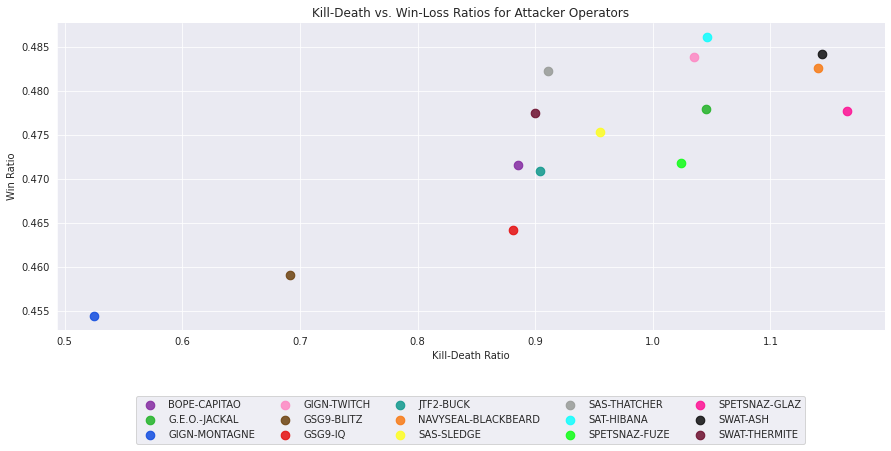

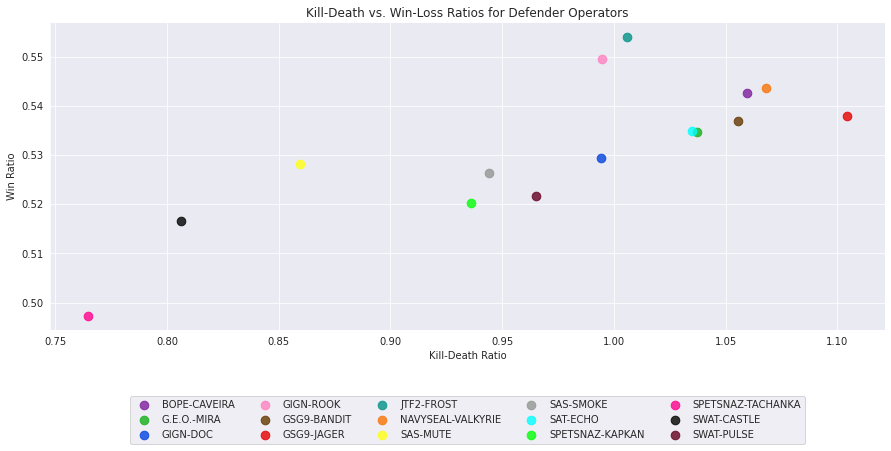

In [92]:
# Graphing Attackers and Defenders on separate graphs
sns.set_style('darkgrid')
for role, tbl in ops_roles:
    sns.lmplot(x="kd_ratio", y="wl_ratio", data=tbl, fit_reg=False, hue='operator', \
               legend=False, palette=new_palette, size=5, aspect=2.5, scatter_kws={"s": 75})
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=5)
    plt.title(f'Kill-Death vs. Win-Loss Ratios for {role} Operators')
    plt.xlabel('Kill-Death Ratio')
    plt.ylabel('Win Ratio')
#plt.tight_layout()  #preference based
plt.show()





#### Overall, the key observations from both charts are that certain operators that receive more kills per death also win more games on average, but that more kills doesn't always equate to more wins.

### <u> Picks and Win/Loss Ratios by Rank:</u>

I shall investigate how the picks rate of certain operators differ across ranks. With any competitive video game, there are Metas.  A Meta is a certain way of doing something in a game that will more often than not guarantee a win.  In other words, its an overpowered game mechanic, operator, or gadget that gets picked or played more often than others. 

I should expect that higher ranked players pick certain operators more often than lower ranked players, because they see their value, or are playing a specific Meta, that lower ranked players might not even be aware of.  This is a classic comparison between a casual player and a professional.

In [93]:
# Create dataframe to sum up rounds won, kills, deaths, and rounds played across all ranks for each rank, role, and operator
ops_by_rank = operators.groupby(['skillrank', 'role', 'operator'], \
                                        as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()

ops_by_rank.head()

,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks
0,Bronze,Attacker,BOPE-CAPITAO,7131,9507,11290,15383
1,Bronze,Attacker,G.E.O.-JACKAL,21358,32434,32760,45492
2,Bronze,Attacker,GIGN-MONTAGNE,12175,9773,19389,26981
3,Bronze,Attacker,GIGN-TWITCH,25733,35115,36318,53941
4,Bronze,Attacker,GSG9-BLITZ,7172,8352,11845,15665


The next question is whether or not standardization is necessary in this project.  To do this, lets look at a histogram of Rank counts in the dataset, to see it a certain Rank is represented disproportionately in the data.  

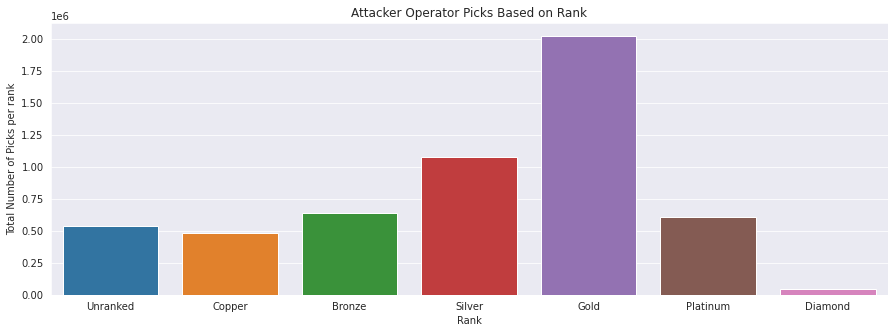

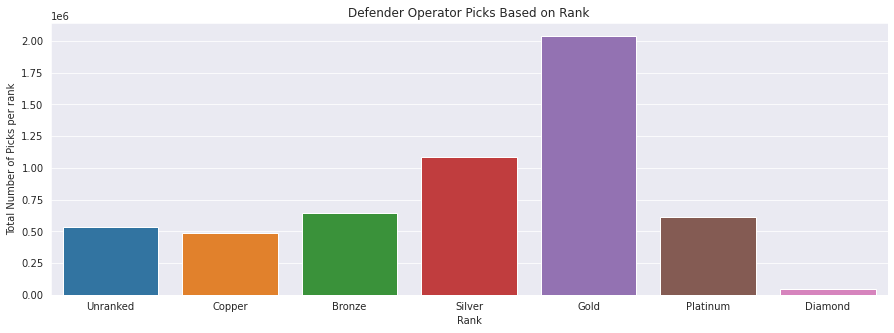

In [94]:
# Group: rank and role
# Summing the number of wins, kills, deaths, and picks for each group
total_ops_by_rank = operators.groupby(['skillrank', 'role'], \
                                        as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()

# Splitting data by role
total_ops_role = total_ops_by_rank.groupby('role')

# Order is used to determine categorical variables for the x-axis
order = ['Unranked','Copper','Bronze','Silver','Gold','Platinum','Diamond']

# Graphing Attackers and Defenders on separate graphs
for role, tbl in total_ops_role:
    plt.figure(figsize=(15,5))
    sns.barplot(x="skillrank", y="nbpicks", data=tbl, order=order)
    plt.title(f'{role} Operator Picks Based on Rank')
    plt.xlabel('Rank')
    plt.ylabel('Total Number of Picks per rank')
#plt.tight_layout()  #preference
plt.show()

Firstly, if both charts appear to be similar, its because they are identical.  This makes sense, because an Attacker of a certain rank is going to be a Defender of that same rank, as teams play both roles each game.  

Secondly, standardization is quite necessary, as the distribution between ranks is not even.  Additionally, the skill gap between ranks is mostly linear up until Gold.  After Gold, the jump to Platinum is exponential, and subsequently, the jump to Diamond is even more exponential.  This means that a Gold player is only a little bit better than a Silver player; but a Diamond player is lightyears ahead of a Gold Player in terms of skill.  We should focus on the Diamond players' pick rates for players, because they are more calculated based on Meta and objective best picks in a certain situation.

To standardize the data, I will use the preprocessing libraru from scikit learn:

In [95]:
frames =  []
sd_ops_by_rank = ops_by_rank.groupby(['skillrank','role'], as_index=False)

for group, tbl in sd_ops_by_rank:
        tbl['scaled_nbpicks'] = preprocessing.scale(tbl['nbpicks'])
        frames.append(tbl)
sd_ops_by_rank = pd.concat(frames)
sd_ops_by_rank.head()

,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks,scaled_nbpicks
0,Bronze,Attacker,BOPE-CAPITAO,7131,9507,11290,15383,-1.468177
1,Bronze,Attacker,G.E.O.-JACKAL,21358,32434,32760,45492,0.149944
2,Bronze,Attacker,GIGN-MONTAGNE,12175,9773,19389,26981,-0.844876
3,Bronze,Attacker,GIGN-TWITCH,25733,35115,36318,53941,0.604011
4,Bronze,Attacker,GSG9-BLITZ,7172,8352,11845,15665,-1.453022


Now that the number of picks for each operator are standardized (within their respective ranks), we can graph the results.

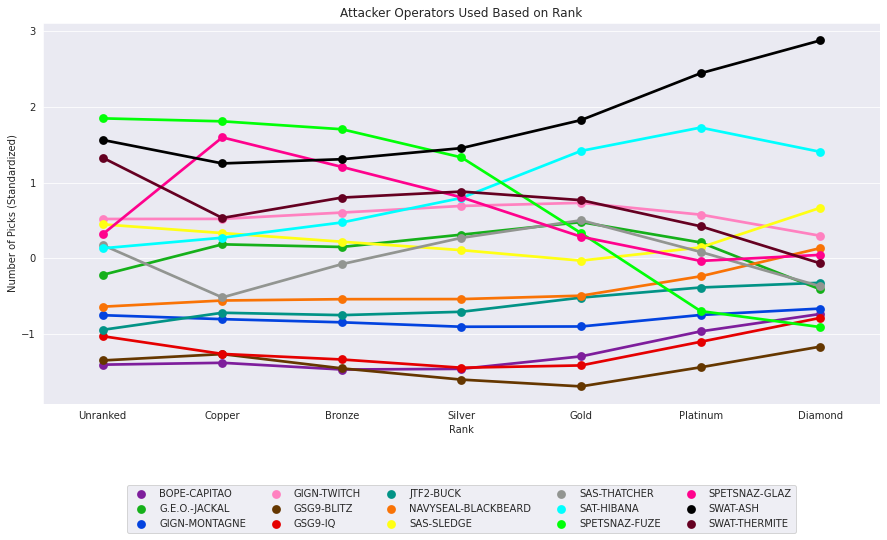

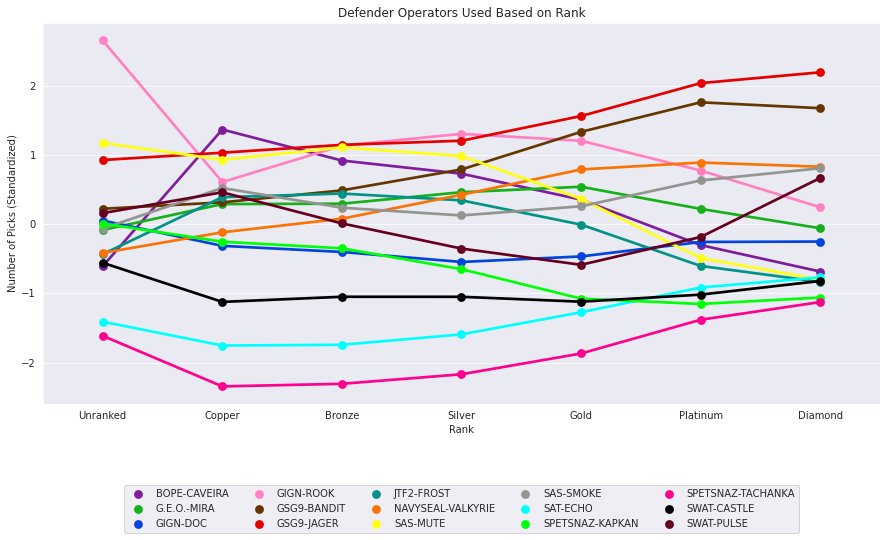

In [96]:
# Order is used to determine categorical variables for the x-axis
order = ['Unranked','Copper','Bronze','Silver','Gold','Platinum','Diamond']

# Splitting data by role
ops_by_rank_role = sd_ops_by_rank.groupby('role')

# Graphing Attackers and Defenders on separate graphs
for role, tbl in ops_by_rank_role:
    plt.figure(figsize=(15,7))
    sns.pointplot(x="skillrank", y="scaled_nbpicks", hue="operator", data=tbl, \
                  legend=False, palette=new_palette, size=5, aspect=2.5, order=order);
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=5)
    plt.title(role +' Operators Used Based on Rank')
    plt.xlabel('Rank')
    plt.ylabel('Number of Picks (Standardized)')
plt.show()

### Kill/Death Ratio vs. Win/Loss Ratio:

The kill/death ratio and win/loss ratio are very well indicators of performance in competitive gaming, and thus I shall require them in my dataset.  They did not come included in the dataset provided by Ubisoft, so I must produce some Feature Engineering to add them.

With these standardized results, we can see which operators are 'preferred', or picked at higher rates than others, across all rank ranges.  

One key feature to note is that while some operators have a steady straight line, meaning theyre picked at realtively the same rate across ranks, others have large dips in pick rate.  

This is where domain knowledge about the game and how the different operators behave with their abilities is beneficial.  As an avid player of Raindbow Six Siege myself, I am not suprised in the slightest about these results.  

The 4 main Attacking operators to focus on are: Ash, Hibana, Sledge, and Fuze.  Ash and Hibana have the highest pick rates, along with Sledge coming in right below them.  Although Fuze has a massive drop in picks in higher ranks; mainly in part because of his gadget being almost useless.  Ash, Hibana, and Sledge on the other hand, have almost 0 compromises in their 'kit': Gun/Attachments, Equipment, Ability Gadget, Armor/Speed ratio.

The 4 main Defending Operators to focus on are: Jager, Caveira, Bandit, Pulse.  Jager is by far the best operator objeviely in the game.  He has aboslutely 0 compromises with his kit:  Acog availibility, one of the highest DPS guns in the game (on defense!), an amazingly useful gadget for the team, and 3 speed making him very quick.  Next with Caveira, we have a significant drop off from lower to higher ranks.  Using domain knowledge about the game, this is because of her ability being almost unstoppable in lower tier rankings, but very easy to counter in higher ranks.  Finally, looking at Pulse, we see that he is picked much more frequently in Diamond ranked games than all others.  Pulse's ability has a very high skill gap, meaning he is harder to use, but once you master his ability, its invaluable.  This might intrigue newer players to pick him in lower ranks, but after they realize his ability is a little tricky, he is picked less; only to skyrocket up again because the Diamond players have mastered his ability.  

#### From these two charts, the main observation is that there are clear 'Meta' players that Diamond players pick for the reason that they are the absolute best pick.  Some operators are fun to play because of their abilities or other components in their 'kit', but are not the absolute best pick; leading to a drop off in pick rate as you increase rank.  Some operator's abilities are more powerful in lower ranks than higher ranks.

Additionally, I want to look at whether certain operators have higher WL ratios in each rank, splitting the data into Attacks and Defenders:

In [97]:
# Empty list of frames, so all the dataframes can be concatenated in the end
frames =  []

# Grouping by skillrank and role
wr_ops_by_rank = ops_by_rank.groupby(['skillrank','role'], as_index=False)

# Calculating win ratio for each grouping
for group, tbl in wr_ops_by_rank:
        tbl['win_ratio'] = pd.to_numeric(tbl['nbwins']) / pd.to_numeric(tbl['nbpicks'])
        frames.append(tbl)
wr_ops_by_rank = pd.concat(frames)
wr_ops_by_rank.head()

,skillrank,role,operator,nbwins,nbkills,nbdeaths,nbpicks,win_ratio
0,Bronze,Attacker,BOPE-CAPITAO,7131,9507,11290,15383,0.463564
1,Bronze,Attacker,G.E.O.-JACKAL,21358,32434,32760,45492,0.469489
2,Bronze,Attacker,GIGN-MONTAGNE,12175,9773,19389,26981,0.451243
3,Bronze,Attacker,GIGN-TWITCH,25733,35115,36318,53941,0.477058
4,Bronze,Attacker,GSG9-BLITZ,7172,8352,11845,15665,0.457836


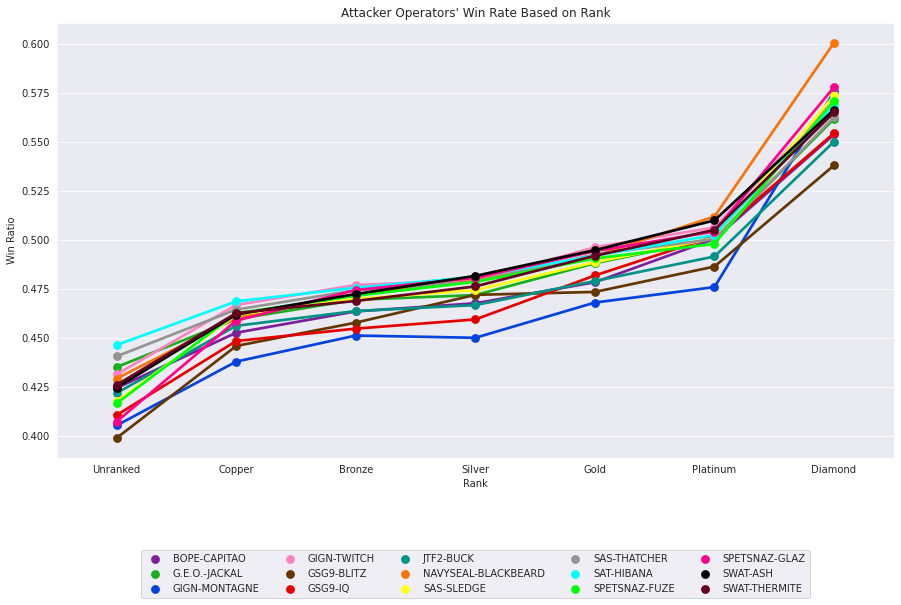

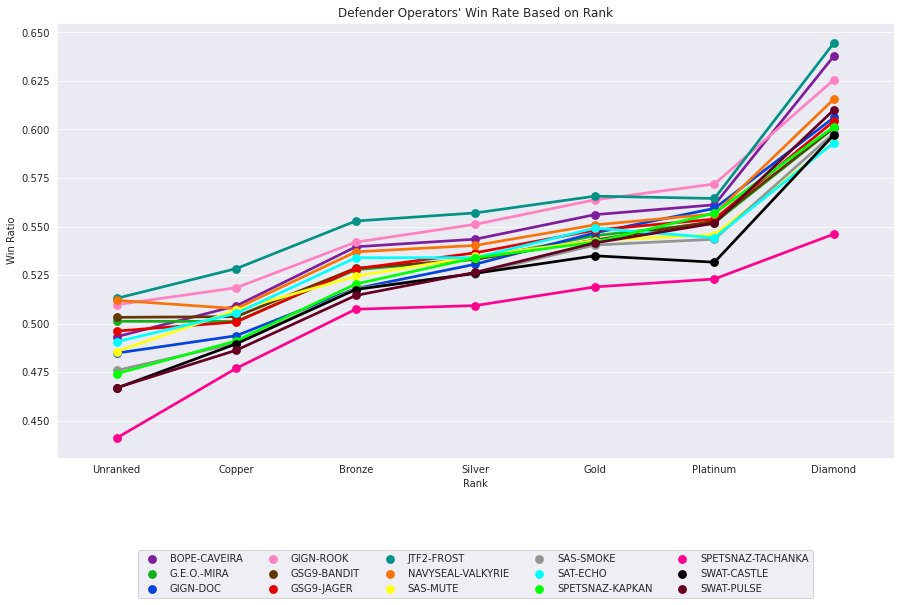

In [98]:
# Splitting data by role
wr_ops_by_rank_role = wr_ops_by_rank.groupby('role')

# Graphing Attackers and Defenders on separate graphs
for role, tbl in wr_ops_by_rank_role:
    plt.figure(figsize=(15,8))
    sns.pointplot(x="skillrank", y="win_ratio", hue="operator", data=tbl, \
                  legend=False, palette=new_palette, size=5, aspect=2.5, order=order);
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=5)
    plt.title(role + ' Operators\' Win Rate Based on Rank')
    plt.xlabel('Rank')
    plt.ylabel('Win Ratio')
plt.show()

From these two charts we can see that for the most part there is a positive correlation with ranking and WL ratio, for every operator. 

For the Attacking operators, Blackbeard, Ash, and Hibana outperform the rest of the operators consistently, with Blackbeard leading the pack in Diamond ranking. 

For Defending Operators, Frost, Rook, Caveira and Valkyrie constantly outperform the rest of the operators.

#### The main take away from these graphs is that the spread of WL ratio depending on operators per rank is minimal, but that there are some key operators that win the most across all ranks.  

### <u> Win Rates Based on Map and Operator:</u>

These next plots will focus on WL ratio, pick rates per player, depending on the map.  For this I will use the objectives datasets

In [99]:
# Group: mapname, role, operator
# Summing number of wins, kills, deaths, and picks for each group
objectives_map = objectives.groupby(['mapname', 'role', 'operator'], as_index=False)\
                    ['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()

# Adding win ratio columns to Objectives data
objectives_map['kd_ratio'] = pd.to_numeric(objectives_map['nbkills']) / pd.to_numeric(objectives_map['nbdeaths'])
objectives_map['win_ratio'] = pd.to_numeric(objectives_map['nbwins']) / pd.to_numeric(objectives_map['nbpicks'])
objectives_map.head()

,mapname,role,operator,nbwins,nbkills,nbdeaths,nbpicks,kd_ratio,win_ratio
0,BANK,Attacker,BOPE-CAPITAO,1902,2778,3201,4321,0.867854,0.440176
1,BANK,Attacker,G.E.O.-JACKAL,7432,12435,11690,16333,1.063730,0.455030
2,BANK,Attacker,GIGN-MONTAGNE,2957,2619,5043,6941,0.519334,0.426019
3,BANK,Attacker,GIGN-TWITCH,6884,10439,10672,15419,0.978167,0.446462
4,BANK,Attacker,GSG9-BLITZ,1075,1311,1963,2556,0.667855,0.420579


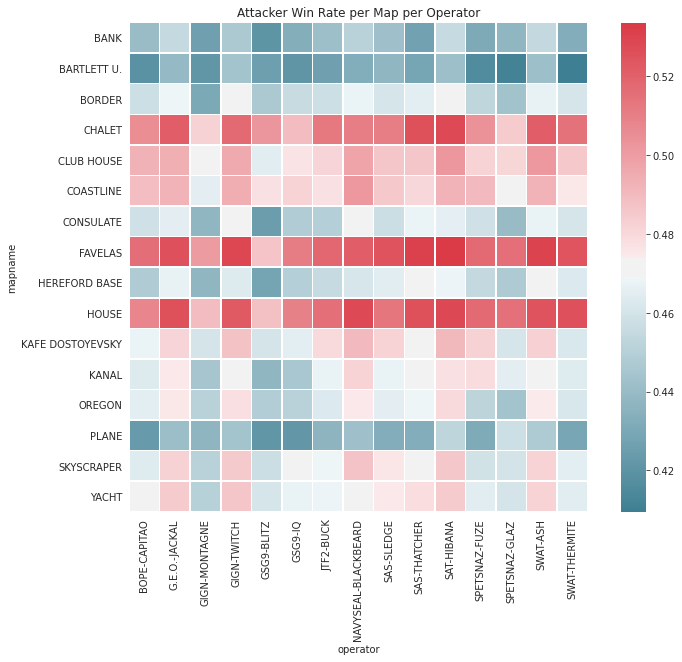

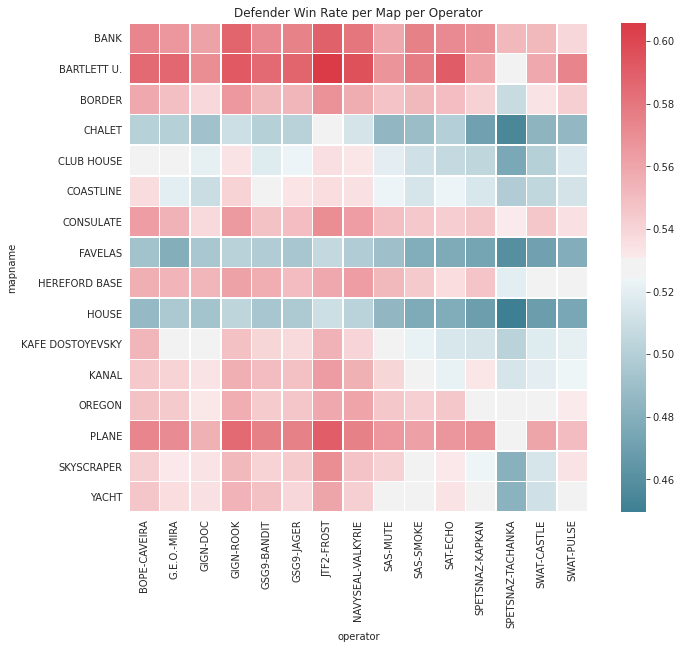

In [100]:
# Create the color scale
cmap = sns.diverging_palette(220,10, as_cmap=True)

# Splitting data by role
objectives_map_role = objectives_map.groupby('role')

# Graph the heat map, warmer color is higher win rate, and vice versa for each role
for role, tbl in objectives_map_role:
    pivot = tbl.pivot(index='mapname', columns='operator', values='win_ratio')
    f, ax = plt.subplots(figsize=(12,9))
    plt.title(f'{role} Win Rate per Map per Operator')
    sns.heatmap(pivot, cmap=cmap, square=True, linewidths=.5, ax=ax)
    
plt.show()


An important question for people not familiar with Rainbow Six Siege is: What do these heatmaps represent?  For both Attackers and Defenders, the Win rate for each operator for each map is displaued.  A perfectly balanced map is where both Defenders and Attackers win 50% or 0.5 of the time. 

The first observation is that Defender's seem to be winning more often than not, with the win rate being greater than 0.5.  This is because for the most part, Attackers have to take the fight to Defenders, whereas Defenders can essentially just hold out to secure a win.  Additionally, there are certain maps where Defenders and Attackers each win most of the time, indicating that those certain maps are not entirely balanced for both roles.  

Secondly from these charts we can see if certain operators perform poorly on certain or all maps.  Theses operators include: Montagne, Blitz, and Glaz on attack, and Tachanka on defense.  On the flipside, operators that perform better than most are: Ash, Hibana, Blackbeard, and Jackal on attack, as well as Frost, Valkyrie and Caveira on defense.

#### The main takeaway from these charts is that certain maps might favor Attackers or Defenders, and that certain operators perform more poorly or better than all other operators consistently.

## <u> Part 5: Regression Analysis: Predicting Win Ratio</u>

In this section, I will focus on developing a model that can accurately predict the win rate of a round between Attackers and Defenders.  Because I have many explanatory variables to examine, I will be using the method of Multiple Linear Regression.

After splitting the data into a training and testing set, I will implement a technique called: One-Hot-Encoding; to transform categorical variables in the dataset to be usable for the Regression Library in Scikit. 

In [101]:
##  Encoding Function
def dummyEncode(df):
    # Filters through dataframe and recognizes categorical variables
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

First, I will add Kill/Death Ratio into the Operators data, as well as remove nbwins, nbkills, nbdeaths, and nbpicks.  

Then, I will pass the DataFrame into the Encoding Function, and add in the Win Ratio as the dependent variable.

#### Operators Dataset:

In [102]:
# Operator Predictors: rank, operator, role, kd
# Create dataframe to sum up rounds won, kills, deaths, and rounds played across all ranks for each rank, role, and operator
ops_by_rank = operators.groupby(['skillrank', 'role', 'operator'], \
                                        as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()

# Adding kill-death and win ratios
ops_by_rank['kd_ratio'] = pd.to_numeric(ops_by_rank['nbkills']) / pd.to_numeric(ops_by_rank['nbdeaths'])
ops_by_rank['win_ratio'] = pd.to_numeric(ops_by_rank['nbwins']) / pd.to_numeric(ops_by_rank['nbpicks'])

# Dropping nbwins, nbkills, nbdeaths, nbpicks
ops_df = ops_by_rank.drop(["nbwins", "nbkills", "nbdeaths", "nbpicks"], axis=1)
ops_df = dummyEncode(ops_df)
ops_df.head()

,skillrank,role,operator,kd_ratio,win_ratio
0,0,0,0,0.842073,0.463564
1,0,0,2,0.990049,0.469489
2,0,0,5,0.504049,0.451243
3,0,0,7,0.966876,0.477058
4,0,0,9,0.705108,0.457836


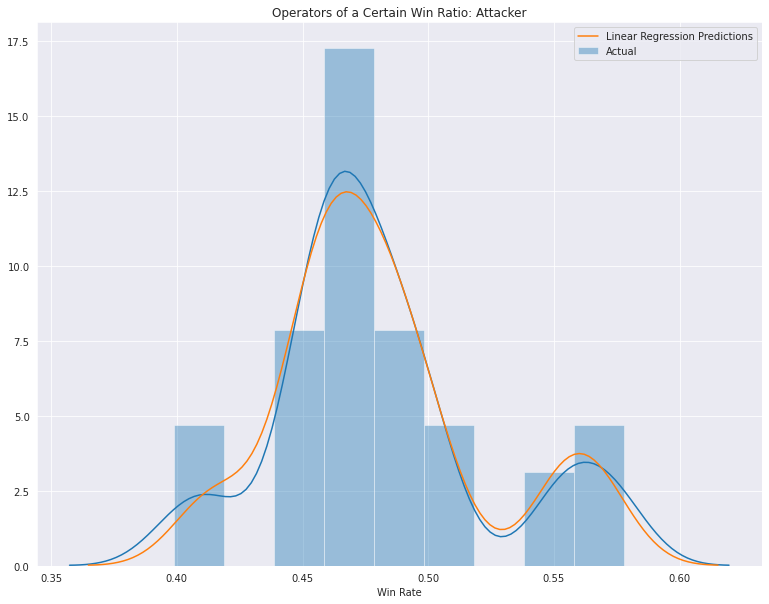

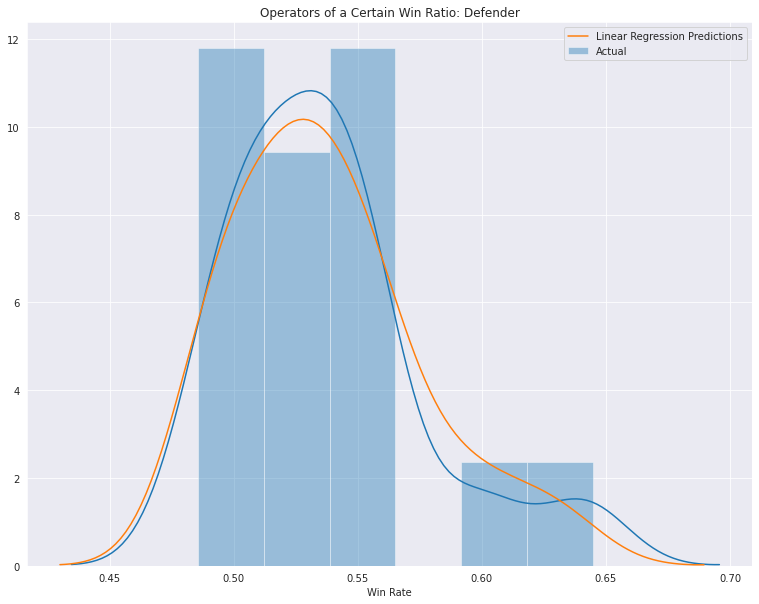

In [109]:
# Split data by Attacker/Defender
ops_df_role = ops_df.groupby('role')
models = []

for role, tbl in ops_df_role:
    X = tbl.drop('win_ratio', axis=1)
    y = tbl['win_ratio']

    # Split data into Train and Test
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3, random_state=11)
    X_train['win_ratio'] = y_train

    # Fit the Linear Regression on Train split
    lr = smf.ols(formula='win_ratio ~ C(skillrank) + C(operator) + kd_ratio', data=X_train).fit()
    models.append(lr)

    # Predict using Test split
    preds_lr = lr.predict(X_test)

    # Plot how the predicted win_ratio compares to actual win ratio
    f, ax = plt.subplots(figsize=(13,10))
    role_name = 'Attacker' if role == 0 else 'Defender'
    plt.title(f'Operators of a Certain Win Ratio: {role_name}')
    sns.distplot(y_test, hist=True, label="Actual", ax=ax)
    sns.distplot(preds_lr, hist=False, label="Linear Regression Predictions", ax=ax).set(xlabel='Win Rate')
plt.show()

Both Attackers and Defenders seem to be following an almost normal distribution around 0.5-0.55.  This would indicate that most operators Win and Lose about 50% of the time, where others Win and Lose a little more or less.

Ideally every single operator would Win/Lose 50% of the time, but this is rarely the case in practice.

Both models performed decently well, so the next step is to conduct an F-test for Goodness of Fit.  

In [104]:
# Import F-Table to look up F-Statistic
from scipy.stats import f

# F-Test to evaluate goodness of fit
for index, model in enumerate(models):
    test = model.f_test(np.identity(len(model.params)))
    role = 'Attacker' if index == 0 else 'Defender'
    print(role + ' Model - Calculated F-Statistic: ' + str(f.ppf(.95,test.df_num,test.df_denom)) + \
          ' F-Value: ' + str(test.fvalue[0][0]) + ' P-Value: ' + str(test.pvalue))

Attacker Model - Calculated F-Statistic: 1.7544740459985062 F-Value: 23425.680296438262 P-Value: 1.6507022503153822e-94
Defender Model - Calculated F-Statistic: 1.7544740459985062 F-Value: 37027.3116175597 P-Value: 1.4062384779877235e-99


Both of these tests were successful with P-values lower than 0.05.

#### Objectives Dataset:

In [105]:
# Objective Predictors: mode, map, rank, operator, role, kd
# Create dataframe to sum up rounds won, kills, deaths, and rounds played across all ranks 
# for each mode, map, rank, operator, role, kd
obj_by_rank = objectives.groupby(['mapname','gamemode','skillrank', 'role', 'operator'], \
                                        as_index=False)['nbwins', 'nbkills', 'nbdeaths', 'nbpicks'].sum()

# Can't divide by 0 in kd if number of deaths is 0. Common procedure to change all of these to a 1
# This is only a problem in the Objectives dataset
mask = obj_by_rank.nbdeaths == 0
obj_by_rank.loc[mask, 'nbdeaths'] = 1

# Adding kill-death and win ratios
obj_by_rank['kd_ratio'] = pd.to_numeric(obj_by_rank['nbkills']) / pd.to_numeric(obj_by_rank['nbdeaths'])
obj_by_rank['win_ratio'] = pd.to_numeric(obj_by_rank['nbwins']) / pd.to_numeric(obj_by_rank['nbpicks'])

obj_df = obj_by_rank.drop(["nbwins", "nbkills", "nbdeaths", "nbpicks"], axis=1)
obj_df = dummyEncode(obj_df)
obj_df.head()

,mapname,gamemode,skillrank,role,operator,kd_ratio,win_ratio
0,0,0,0,0,0,0.812500,0.460317
1,0,0,0,0,2,1.148594,0.429379
2,0,0,0,0,5,0.413534,0.396552
3,0,0,0,0,7,0.835938,0.424403
4,0,0,0,0,9,0.675325,0.416667


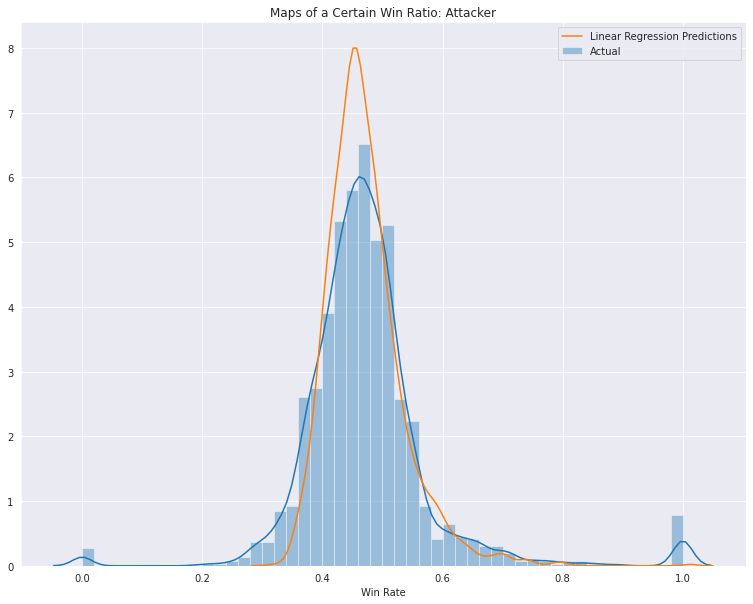

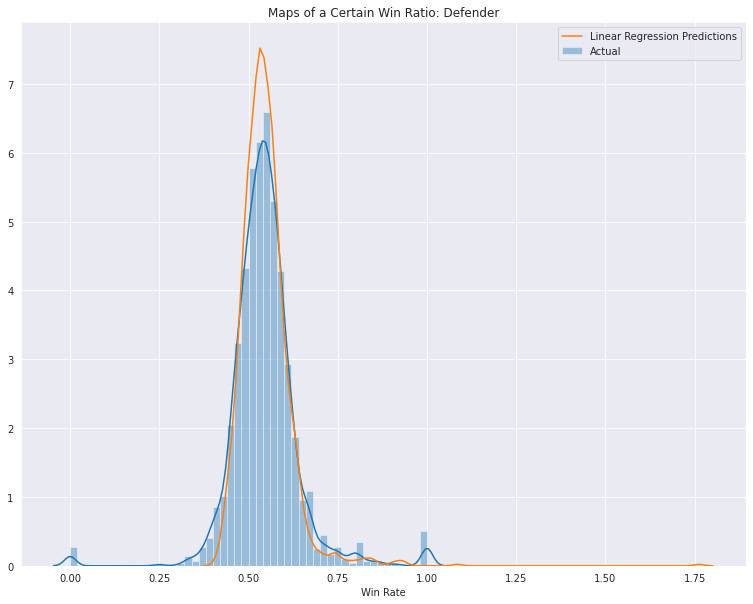

In [110]:
obj_df_role = obj_df.groupby('role')
models_obj = []

for role, tbl in obj_df_role:
    X = tbl.drop('win_ratio', axis=1)
    y = tbl['win_ratio']

    # Split data into Train and Test
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3)
    X_train['win_ratio'] = y_train

    # Fit the Linear Regression on Train split
    lr = smf.ols(formula='win_ratio ~ C(mapname) + C(gamemode) + C(skillrank) + C(operator) + kd_ratio', data=X_train).fit()
    models_obj.append(lr)

    # Predict using Test split
    preds_lr = lr.predict(X_test)

    # Plot how the predicted win_ratio compares to actual win ratio
    f, ax = plt.subplots(figsize=(13,10))
    role_name = 'Attacker' if role == 0 else 'Defender'
    plt.title(f'Maps of a Certain Win Ratio: {role_name}')
    sns.distplot(y_test, hist=True, label="Actual", ax=ax)
    sns.distplot(preds_lr, hist=False, label="Linear Regression Predictions", ax=ax).set(xlabel='Win Rate')

plt.show()

Conducting another F-test:

In [107]:
# Import F-Table to look up F-Statistic
from scipy.stats import f

# F-Test to evaluate goodness of fit
for index, model in enumerate(models_obj):
    test = model.f_test(np.identity(len(model.params)))
    role = 'Attacker' if index == 0 else 'Defender'
    print(role + ' Model - Calculated F-Statistic: ' + str(f.ppf(.95,test.df_num,test.df_denom)) + \
          ' F-Value: ' + str(test.fvalue[0][0]) + ' P-Value: ' + str(test.pvalue))

Attacker Model - Calculated F-Statistic: 1.4029074107285506 F-Value: 2855.1319683921283 P-Value: 0.0
Defender Model - Calculated F-Statistic: 1.4029138157421583 F-Value: 3572.2629871376894 P-Value: 0.0


Both tests pass with a P-value being less than 0.05.

## <u> Part 6: Conclusion </u>

Over the course of this project, the concept of balance in competitive video games was visited through Rainbow Six Siege.  Through the process of multiple linear regression, we were able to accurately predict the Win Rate of different operator characters in the game as well as the Win Rates for Attackers and Defenders for each map.  Through EDA, we explored pick rates of different operators, KD ratios of different operators throughout different rank ranges, as well as the WL ratios and saw a positive correlation between receiving kills and wins.  Additionally, there were a few operators on Attack and Defense where their pick rates were higher and lower than most, and Win/Loss ratios also higher.  This might indicate that there is some imbalance in how they operate compared to the rest.  Finally, the heatmaps we produced showed that certain maps had Attackers or Defenders winning most of the time; around 55-60%.  These maps will need to be reworked/altered, or completely taken out of the game to keep Rainbow Six Siege perfectly competitive, and as close to balanced as possible.  If these changes are implemented, then the game will continue to be one of the most fun and competitive shooters on the market.